In [1]:
import cymetric as cym
import pandas as pd

import numpy as np
import sklearn as skl
import random
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (40,24)
from cymetric import graphs as cgr
from cymetric import timeseries as tm
from cymetric import filters as fl

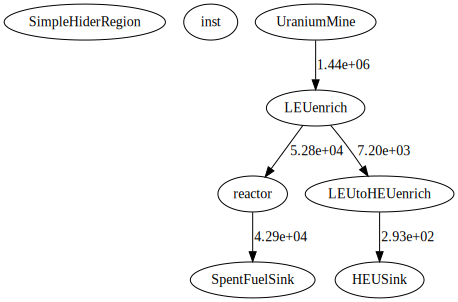

In [2]:
file = "0309base.sqlite"
db = cym.dbopen(file)
ev = cym.Evaluator(db=db, write=True)
cym.graphs.flow_graph(ev, label = "mass")

#### extract data from the sqlite file

In [3]:
def tidy_df(file):
    db = cym.dbopen(file)
    ev = cym.Evaluator(db=db, write=True)
    
    agentTable = ev.eval("AgentEntry")
    agents = agentTable.loc[:, ["AgentId", "Prototype"]]
    
    transTable = ev.eval("Transactions")
    transactions = transTable.loc[:, ["SenderId", "ReceiverId", "ResourceId", "Commodity", "Time"]]
    
    resourceTable = ev.eval("Resources")
    resources = resourceTable.loc[:, ["ResourceId", "Quantity"]]
    
    #merge agents, transactions, and resources
    int1 = pd.merge(transactions, resources, on='ResourceId', how='inner')

    #rename AgentId column to facilitate merge 
    send = agents.rename(columns = {"AgentId": "SenderId"})
    receive = agents.rename(columns = {"AgentId": "ReceiverId"})

    for i in range(len(int1)):
        for j in range(len(send)):
            if int1.loc[i,"SenderId"] == send.loc[j, "SenderId"]:
                int1.loc[i,"SenderId"] = send.loc[j, "Prototype"]
                
    for i in range(len(int1)):
        for j in range(len(receive)):
            if int1.loc[i,"ReceiverId"] == receive.loc[j, "ReceiverId"]:
                int1.loc[i,"ReceiverId"] = receive.loc[j, "Prototype"]

    
    return int1
    

#### trim resource-identifying columns

In [4]:
def trim_data(df):
    trimmed = df[["SenderId", "ReceiverId", "Time", "Quantity"]]
    trimmed["fraction"] = pd.Series(0, index = range(316)) #modular? 
    trimmed["truck"] = pd.Series(0, index = range(316))
    
    #assume leu and heu enrichment happens in the same physical facility
    #drop rows with transactions between enrichment facilities
    short = trimmed.loc[(trimmed['SenderId'] != "LEUenrich") & (trimmed['ReceiverId'] != "LEUtoHEUenrich")]
    
    #change the name of enrichment facilites 
    short["SenderId"] = short['SenderId'].replace({'LEUenrich': 'enrichment', 'LEUtoHEUenrich': 'enrichment'})
    short['ReceiverId'] = short['ReceiverId'].replace({'LEUenrich': 'enrichment', 'LEUtoHEUenrich': 'enrichment'})
    
    return short

#### define truck

for each transaction, cap shipment at a certain mass m ( = 25000kg? is realisitc, but a smaller value might be more interesting)
create a new column with the number of trucks sent for this interaction (0 + )
consider storing heu for several timesteps


In [5]:
def send_trucks(truck_df, truck_size): 
    truck_df["fraction"] = truck_df["Quantity"] / truck_size
    print(truck_df.head())
    MtoE = 0
    EtoSink = 0
    EtoR = 0
    RtoSink = 0
    for index, row in truck_df.iterrows(): 
        if row["SenderId"] == "UraniumMine" and row["ReceiverId"] == "enrichment":
            MtoE += row["fraction"]
            if MtoE > 1:
                truck_df.loc[index, "truck"] = 1
                MtoE -= 1
        if row["SenderId"] == "enrichment" and row["ReceiverId"] == "HEUSink":
            EtoSink += row["fraction"]
            if EtoSink > 1:
                truck_df.loc[index, "truck"] = 1
                EtoSink -= 1
        if row["SenderId"] == "enrichment" and row["ReceiverId"] == "reactor":
            EtoR += row["fraction"]
            if EtoR > 1:
                truck_df.loc[index, "truck"] = 1
                EtoR -=1
        if row["SenderId"] == "reactor" and row["ReceiverId"] == "SpentFuelSink":
            RtoSink += row["fraction"]
            if RtoSink > 1:
                truck_df.loc[index, "truck"] = 1
                RtoSink -=1
    return truck_df
    

#### flatten data into single row for use with other runs

columns: every perumutation of transaction (truck boolean), every timestamp

row: single cyclus run 

transactions: mine to enrichment, enrichment to reactor, reactor to sf sink, enrichment to heu sink

In [6]:
def make_cols(max_time):
    col_names = []
    transactions = ["mine--enrich", "enrich--reactor", "enrich--heusink", "reactor--sfsink"]
    for t in range(max_time):
        for trans in transactions: 
            col_names.append(trans + "|time" + str(t))
    return col_names
 
def make_row(truckdf, max_time):
    long_row = []
    for t in range(max_time):
        #subset rows with this timestep
        subset = truckdf.loc[truckdf['Time'] == t]
        sub_row = [0,0,0,0]
        for index, row in subset.iterrows():
            #check each possible transaction
            if row["SenderId"] == "UraniumMine" and row["ReceiverId"] == "enrichment":
                #sub_row[0] = ("mine--enrich") #switch to the number of trucks sent!
                sub_row[0] = truckdf.loc[index, "truck"]
                
            if row["SenderId"] == "enrichment" and row["ReceiverId"] == "reactor":
                sub_row[1] = truckdf.loc[index, "truck"]

            if row["SenderId"] == "enrichment" and row["ReceiverId"] == "HEUSink":
                sub_row[2] = truckdf.loc[index, "truck"]

            if row["SenderId"] == "reactor" and row["ReceiverId"] == "SpentFuelSink":
                sub_row[3] = truckdf.loc[index, "truck"]
        long_row.extend(sub_row)
    return long_row

In [7]:
def file_to_line(filename, truck_size, max_time):
    return make_row(send_trucks(trim_data(tidy_df(filename)), truck_size), max_time)
    
def simulation_data(files, truck_size, max_time):
    columns = make_cols(max_time)
    rows = []
    for file in files: 
        rows.append(file_to_line(file, truck_size, max_time))
    return pd.DataFrame(data = rows, columns = columns)

In [8]:
simulation_data(["0309base.sqlite", "0309reactor4.sqlite"], 12000, 144)

/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/local/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/opt/local/Library/Frameworks/Python.framework/Versions/3.6

      SenderId  ReceiverId  Time      Quantity  fraction  truck
0  UraniumMine  enrichment     0  10000.000000  0.833333      0
1  UraniumMine  enrichment     1  10000.000000  0.833333      0
3   enrichment     HEUSink     2      4.124861  0.000344      0
4  UraniumMine  enrichment     2  10000.000000  0.833333      0
5  UraniumMine  enrichment     3  10000.000000  0.833333      0
      SenderId  ReceiverId  Time  Quantity  fraction  truck
0  UraniumMine  enrichment     0   10000.0  0.833333      0
1  UraniumMine  enrichment     1   10000.0  0.833333      0
2  UraniumMine  enrichment     2   10000.0  0.833333      0
3  UraniumMine  enrichment     3   10000.0  0.833333      0
5  UraniumMine  enrichment     4   10000.0  0.833333      0


,mine--enrich|time0,enrich--reactor|time0,enrich--heusink|time0,reactor--sfsink|time0,mine--enrich|time1,enrich--reactor|time1,enrich--heusink|time1,reactor--sfsink|time1,mine--enrich|time2,enrich--reactor|time2,...,enrich--heusink|time141,reactor--sfsink|time141,mine--enrich|time142,enrich--reactor|time142,enrich--heusink|time142,reactor--sfsink|time142,mine--enrich|time143,enrich--reactor|time143,enrich--heusink|time143,reactor--sfsink|time143
0,0,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
1,0,0,0,0,1,0,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
